In [5]:
import torch
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
device=torch.device('cuda:1')
torch.cuda.set_device(device)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [2]:
# reload ScalingDimensions
import importlib
import ScalingDimensions
importlib.reload(ScalingDimensions)

from ScalingDimensions import show_diff,show_scaling_dimensions,get_scaling_dimensions

  0%|          | 0/61 [00:00<?, ?it/s]

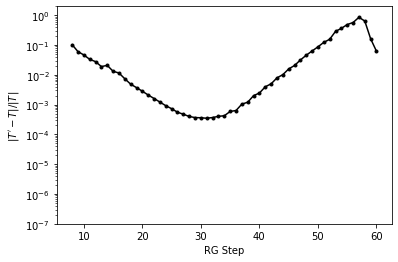

In [3]:
optionsM,paramsM,layersM,TsM,logTotalsM=torch.load('data/hotrg_gilt_X24.pth',map_location=device)
curveM=show_diff(TsM,stride=2)

T0=TsM[20]
layers=layersM[20:22]
options=optionsM

In [7]:
from HOTRGZ2 import HOTRG_layer,forward_layer
from utils import show_tensor_ijkl
from tqdm import tqdm

def evolve(T):
    with torch.no_grad():
        T1,layer1=HOTRG_layer(T,T,options['max_dim'],options=options)
        T2,layer2=HOTRG_layer(T1,T1,options['max_dim'],options=options,Tref=T)
    T1=forward_layer(T,T,layer1)
    T2=forward_layer(T1,T1,layer2)
    return T2
    

def loss(T):
    T=T/T.norm()
    T2=evolve(T)
    T2=T2/T2.norm()
    return (T-T2).norm()

# verify T by showing its scdim
from ScalingDimensions import get_scaling_dimensions,get_transfer_matrix_spectrum_2D
def verify(T):
    spectrum=get_transfer_matrix_spectrum_2D(T,loop_length=2)[1]
    scdim=get_scaling_dimensions(spectrum,scaling=np.exp(2*np.pi/2))
    print(scdim[:10])

verify(TsM[20])
print(loss(TsM[20]))
verify(TsM[30])
print(loss(TsM[30]))


tensor([0.0000, 0.1256, 1.0086, 1.1360, 1.1364, 2.0291, 2.0293, 2.0317, 2.0364,
        2.1541])
tensor(0.0016)
tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0354, 2.0357, 2.0382, 2.0427,
        2.1608])
tensor(0.0003)


In [9]:

T0=TsM[30]

# optimize loss of T0, using adam. lr is determined loss
from torch import optim
T=T0.clone().detach().requires_grad_(True)
optimizer=optim.Adam([T],lr=1e-2)
avgloss=None
for i in tqdm(range(1000)):
    optimizer.zero_grad()
    L=loss(T)
    # adjust lr
    avgloss=0.9*avgloss+0.1*L.item() if avgloss is not None else L.item()
    optimizer.param_groups[0]['lr']=avgloss*1e-4

    L.backward()
    optimizer.step()
    
    if i%1==0:
        print('step',i,'loss',L.item(),'lr',optimizer.param_groups[0]['lr'])
        verify(T.data)


  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

step 0 loss 0.0003131771092209458 lr 3.131771092209458e-08


  0%|                                                                                | 1/1000 [00:04<1:22:53,  4.98s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0354, 2.0358, 2.0382, 2.0427,
        2.1608])
step 1 loss 0.000311392471396669 lr 3.1299864543851816e-08


  0%|▏                                                                               | 2/1000 [00:09<1:19:31,  4.78s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0354, 2.0359, 2.0381, 2.0427,
        2.1609])
step 2 loss 0.00030842966616597854 lr 3.125417475112642e-08


  0%|▏                                                                               | 3/1000 [00:14<1:18:25,  4.72s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0354, 2.0360, 2.0381, 2.0427,
        2.1609])
step 3 loss 0.00030575929532890506 lr 3.1186350229302835e-08


  0%|▎                                                                               | 4/1000 [00:18<1:18:18,  4.72s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0355, 2.0360, 2.0381, 2.0427,
        2.1609])
step 4 loss 0.0003040524228629868 lr 3.1108239435002416e-08


  0%|▍                                                                               | 5/1000 [00:23<1:17:47,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0355, 2.0361, 2.0381, 2.0427,
        2.1609])
step 5 loss 0.00030192398384553624 lr 3.101665532995754e-08


  1%|▍                                                                               | 6/1000 [00:28<1:17:46,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0355, 2.0362, 2.0381, 2.0427,
        2.1610])
step 6 loss 0.0002995190272640946 lr 3.091018006960274e-08


  1%|▌                                                                               | 7/1000 [00:33<1:17:42,  4.70s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0355, 2.0362, 2.0381, 2.0427,
        2.1610])
step 7 loss 0.0002975120080787438 lr 3.0794282143429904e-08


  1%|▋                                                                               | 8/1000 [00:37<1:17:20,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0355, 2.0363, 2.0380, 2.0427,
        2.1610])
step 8 loss 0.00029598639968004176 lr 3.0674717925887335e-08


  1%|▋                                                                               | 9/1000 [00:42<1:17:11,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0355, 2.0363, 2.0380, 2.0427,
        2.1610])
step 9 loss 0.0002944726008295264 lr 3.055197214159387e-08


  1%|▊                                                                              | 10/1000 [00:46<1:17:03,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0355, 2.0364, 2.0380, 2.0427,
        2.1610])
step 10 loss 0.0002927085973471606 lr 3.0423860900906086e-08


  1%|▊                                                                              | 11/1000 [00:51<1:16:52,  4.66s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0355, 2.0364, 2.0380, 2.0427,
        2.1611])
step 11 loss 0.00029088386676286295 lr 3.029031347844411e-08


  1%|▉                                                                              | 12/1000 [00:56<1:16:49,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0355, 2.0365, 2.0380, 2.0428,
        2.1611])
step 12 loss 0.0002892512449000925 lr 3.0153794579600625e-08


  1%|█                                                                              | 13/1000 [01:00<1:16:37,  4.66s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0356, 2.0365, 2.0380, 2.0428,
        2.1611])
step 13 loss 0.0002878463125224832 lr 3.0016878246865394e-08


  1%|█                                                                              | 14/1000 [01:05<1:16:37,  4.66s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0356, 2.0366, 2.0380, 2.0428,
        2.1611])
step 14 loss 0.0002865196217006594 lr 2.9880386639185446e-08


  2%|█▏                                                                             | 15/1000 [01:10<1:16:26,  4.66s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0356, 2.0366, 2.0380, 2.0428,
        2.1611])
step 15 loss 0.0002851540195850907 lr 2.9743888171117813e-08


  2%|█▎                                                                             | 16/1000 [01:14<1:16:25,  4.66s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0356, 2.0367, 2.0380, 2.0428,
        2.1612])
step 16 loss 0.0002837744728971405 lr 2.960724408297744e-08


  2%|█▎                                                                             | 17/1000 [01:19<1:16:32,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0356, 2.0367, 2.0380, 2.0428,
        2.1612])
step 17 loss 0.000282466572317641 lr 2.947118539785611e-08


  2%|█▍                                                                             | 18/1000 [01:24<1:16:28,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0356, 2.0367, 2.0380, 2.0428,
        2.1612])
step 18 loss 0.00028126432424420216 lr 2.9336710100512523e-08


  2%|█▌                                                                             | 19/1000 [01:28<1:16:27,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0356, 2.0368, 2.0380, 2.0428,
        2.1612])
step 19 loss 0.0002801254608404413 lr 2.9204293698865688e-08


  2%|█▌                                                                             | 20/1000 [01:33<1:16:18,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1398, 2.0356, 2.0368, 2.0380, 2.0428,
        2.1612])
step 20 loss 0.0002789925586902562 lr 2.9073789915881683e-08


  2%|█▋                                                                             | 21/1000 [01:38<1:16:11,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1399, 2.0356, 2.0369, 2.0380, 2.0428,
        2.1612])
step 21 loss 0.00027785438286251417 lr 2.8944954752918654e-08


  2%|█▋                                                                             | 22/1000 [01:43<1:16:21,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1399, 2.0356, 2.0369, 2.0380, 2.0428,
        2.1613])
step 22 loss 0.00027674558648614264 lr 2.881791514248822e-08


  2%|█▊                                                                             | 23/1000 [01:47<1:16:12,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1399, 2.0356, 2.0369, 2.0380, 2.0428,
        2.1613])
step 23 loss 0.00027570124653648615 lr 2.869313609360426e-08


  2%|█▉                                                                             | 24/1000 [01:52<1:16:10,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1399, 2.0356, 2.0370, 2.0380, 2.0428,
        2.1613])
step 24 loss 0.0002747229893182523 lr 2.8571052377426355e-08


  2%|█▉                                                                             | 25/1000 [01:57<1:15:59,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1399, 2.0356, 2.0370, 2.0380, 2.0428,
        2.1613])
step 25 loss 0.0002737894622849135 lr 2.8451841762532852e-08


  3%|██                                                                             | 26/1000 [02:01<1:15:53,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1399, 2.0356, 2.0370, 2.0380, 2.0428,
        2.1613])
step 26 loss 0.00027288446398412416 lr 2.833550222612081e-08


  3%|██▏                                                                            | 27/1000 [02:06<1:15:57,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1399, 2.0356, 2.0371, 2.0380, 2.0428,
        2.1613])
step 27 loss 0.0002729711083355174 lr 2.82316630868639e-08


  3%|██▏                                                                            | 28/1000 [02:11<1:15:46,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1394, 1.1399, 2.0356, 2.0371, 2.0380, 2.0428,
        2.1613])
step 28 loss 0.0002719176314636054 lr 2.8127673092813563e-08


  3%|██▎                                                                            | 29/1000 [02:15<1:15:45,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0371, 2.0380, 2.0428,
        2.1613])
step 29 loss 0.0002708949650931537 lr 2.8023855434463746e-08


  3%|██▎                                                                            | 30/1000 [02:20<1:15:39,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0372, 2.0381, 2.0428,
        2.1614])
step 30 loss 0.00026994764858825833 lr 2.7920946376899954e-08


  3%|██▍                                                                            | 31/1000 [02:25<1:15:33,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0372, 2.0381, 2.0429,
        2.1614])
step 31 loss 0.00026905841554685466 lr 2.7819435894678506e-08


  3%|██▌                                                                            | 32/1000 [02:29<1:15:43,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0372, 2.0381, 2.0429,
        2.1614])
step 32 loss 0.0002681916509922679 lr 2.7719408815133338e-08


  3%|██▌                                                                            | 33/1000 [02:34<1:15:28,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0372, 2.0381, 2.0429,
        2.1614])
step 33 loss 0.00026732494276911266 lr 2.762071736131113e-08


  3%|██▋                                                                            | 34/1000 [02:39<1:15:17,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0372, 2.0381, 2.0429,
        2.1614])
step 34 loss 0.0002664500014554882 lr 2.7523145639734902e-08


  4%|██▊                                                                            | 35/1000 [02:43<1:15:24,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0373, 2.0381, 2.0429,
        2.1614])
step 35 loss 0.00026556833309720026 lr 2.7426514406733414e-08


  4%|██▊                                                                            | 36/1000 [02:48<1:15:11,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0373, 2.0381, 2.0429,
        2.1614])
step 36 loss 0.00026468930271123447 lr 2.7330755993172418e-08


  4%|██▉                                                                            | 37/1000 [02:53<1:15:12,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0373, 2.0381, 2.0429,
        2.1614])
step 37 loss 0.0002642714255371291 lr 2.724039464922647e-08


  4%|███                                                                            | 38/1000 [02:57<1:15:09,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0373, 2.0381, 2.0429,
        2.1614])
step 38 loss 0.00026339880537338113 lr 2.7150343238037628e-08


  4%|███                                                                            | 39/1000 [03:02<1:15:04,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0373, 2.0381, 2.0429,
        2.1614])
step 39 loss 0.00026253068034884136 lr 2.706061571772228e-08


  4%|███▏                                                                           | 40/1000 [03:07<1:14:50,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0373, 2.0381, 2.0429,
        2.1614])
step 40 loss 0.0002617133034631648 lr 2.6971687180581705e-08


  4%|███▏                                                                           | 41/1000 [03:11<1:14:43,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0373, 2.0381, 2.0429,
        2.1614])
step 41 loss 0.00026094941594650034 lr 2.6884012621988537e-08


  4%|███▎                                                                           | 42/1000 [03:16<1:14:40,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0373, 2.0381, 2.0429,
        2.1614])
step 42 loss 0.00026022109775849714 lr 2.6797822337374658e-08


  4%|███▍                                                                           | 43/1000 [03:21<1:14:36,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0373, 2.0382, 2.0429,
        2.1614])
step 43 loss 0.0002595126609918662 lr 2.6713166713555853e-08


  4%|███▍                                                                           | 44/1000 [03:25<1:14:24,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0373, 2.0382, 2.0429,
        2.1614])
step 44 loss 0.0002588155216927923 lr 2.6630005259128196e-08


  4%|███▌                                                                           | 45/1000 [03:30<1:14:33,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0382, 2.0429,
        2.1614])
step 45 loss 0.00025812955001894793 lr 2.6548300233404856e-08


  5%|███▋                                                                           | 46/1000 [03:35<1:14:30,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0382, 2.0429,
        2.1614])
step 46 loss 0.0002574616187110743 lr 2.6468086397175112e-08


  5%|███▋                                                                           | 47/1000 [03:40<1:14:21,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0382, 2.0429,
        2.1614])
step 47 loss 0.0002568176961871286 lr 2.6389454719328888e-08


  5%|███▊                                                                           | 48/1000 [03:44<1:14:26,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0382, 2.0429,
        2.1614])
step 48 loss 0.00025619765557779935 lr 2.6312485803173995e-08


  5%|███▊                                                                           | 49/1000 [03:49<1:14:21,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0382, 2.0429,
        2.1614])
step 49 loss 0.00025559905969701986 lr 2.6237227819826796e-08


  5%|███▉                                                                           | 50/1000 [03:54<1:14:09,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0382, 2.0429,
        2.1614])
step 50 loss 0.0002550222835372864 lr 2.6163727873216983e-08


  5%|████                                                                           | 51/1000 [03:58<1:14:14,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0382, 2.0429,
        2.1614])
step 51 loss 0.0002544688770962652 lr 2.609204385685794e-08


  5%|████                                                                           | 52/1000 [04:03<1:14:05,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0382, 2.0429,
        2.1614])
step 52 loss 0.0002539370744039112 lr 2.6022210215211256e-08


  5%|████▏                                                                          | 53/1000 [04:08<1:14:00,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0382, 2.0429,
        2.1614])
step 53 loss 0.0002534218279178347 lr 2.5954207472868476e-08


  5%|████▎                                                                          | 54/1000 [04:12<1:14:00,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0382, 2.0429,
        2.1614])
step 54 loss 0.00025291857802658616 lr 2.588797250584749e-08


  6%|████▎                                                                          | 55/1000 [04:17<1:13:51,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0382, 2.0429,
        2.1614])
step 55 loss 0.00025242482438943563 lr 2.58234234991571e-08


  6%|████▍                                                                          | 56/1000 [04:22<1:14:03,  4.71s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0382, 2.0429,
        2.1614])
step 56 loss 0.00025193792914048995 lr 2.576046044064629e-08


  6%|████▌                                                                          | 57/1000 [04:27<1:13:54,  4.70s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0383, 2.0429,
        2.1614])
step 57 loss 0.00025145347756067043 lr 2.5698949172188372e-08


  6%|████▌                                                                          | 58/1000 [04:31<1:13:39,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0383, 2.0429,
        2.1614])
step 58 loss 0.00025096723673853703 lr 2.5638726622354904e-08


  6%|████▋                                                                          | 59/1000 [04:36<1:13:39,  4.70s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0383, 2.0429,
        2.1614])
step 59 loss 0.0002504781198637826 lr 2.5579635158757242e-08


  6%|████▋                                                                          | 60/1000 [04:41<1:13:31,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0356, 2.0374, 2.0383, 2.0430,
        2.1614])
step 60 loss 0.0002499884873593975 lr 2.5521556516475493e-08


  6%|████▊                                                                          | 61/1000 [04:45<1:13:39,  4.71s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0383, 2.0430,
        2.1614])
step 61 loss 0.00024950221545449514 lr 2.54644230193729e-08


  6%|████▉                                                                          | 62/1000 [04:50<1:13:28,  4.70s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0383, 2.0430,
        2.1614])
step 62 loss 0.0002490231937927419 lr 2.540821265536303e-08


  6%|████▉                                                                          | 63/1000 [04:55<1:13:19,  4.70s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0383, 2.0430,
        2.1614])
step 63 loss 0.000249247113817823 lr 2.5359862528004958e-08


  6%|█████                                                                          | 64/1000 [04:59<1:13:23,  4.70s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0383, 2.0430,
        2.1614])
step 64 loss 0.0002487594947004216 lr 2.531147122220868e-08


  6%|█████▏                                                                         | 65/1000 [05:04<1:13:10,  4.70s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0383, 2.0430,
        2.1614])
step 65 loss 0.0002476406740060547 lr 2.525673084004836e-08


  7%|█████▏                                                                         | 66/1000 [05:09<1:13:09,  4.70s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0383, 2.0430,
        2.1614])
step 66 loss 0.00024718891255273766 lr 2.52029468815709e-08


  7%|█████▎                                                                         | 67/1000 [05:14<1:13:02,  4.70s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0383, 2.0430,
        2.1614])
step 67 loss 0.0002472928036467937 lr 2.515558022988175e-08


  7%|█████▎                                                                         | 68/1000 [05:18<1:12:56,  4.70s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0383, 2.0430,
        2.1614])
step 68 loss 0.0002462556390871499 lr 2.5102578597765075e-08


  7%|█████▍                                                                         | 69/1000 [05:23<1:12:55,  4.70s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0383, 2.0430,
        2.1614])
step 69 loss 0.00024579229544816815 lr 2.5050243692470247e-08


  7%|█████▌                                                                         | 70/1000 [05:28<1:12:38,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0384, 2.0430,
        2.1614])
step 70 loss 0.0002453385887923553 lr 2.4998605211146776e-08


  7%|█████▌                                                                         | 71/1000 [05:32<1:12:40,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0384, 2.0430,
        2.1614])
step 71 loss 0.00024547008766796975 lr 2.4953445566711795e-08


  7%|█████▋                                                                         | 72/1000 [05:37<1:12:36,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0384, 2.0430,
        2.1614])
step 72 loss 0.0002450137102183869 lr 2.4908238112224487e-08


  7%|█████▊                                                                         | 73/1000 [05:42<1:12:26,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0384, 2.0430,
        2.1614])
step 73 loss 0.0002440659427519648 lr 2.4858073728521686e-08


  7%|█████▊                                                                         | 74/1000 [05:46<1:12:22,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0384, 2.0430,
        2.1614])
step 74 loss 0.0002436679310731518 lr 2.480894566640104e-08


  8%|█████▉                                                                         | 75/1000 [05:51<1:12:16,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0384, 2.0430,
        2.1614])
step 75 loss 0.00024326968189936204 lr 2.4760747918754557e-08


  8%|██████                                                                         | 76/1000 [05:56<1:12:13,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0384, 2.0430,
        2.1614])
step 76 loss 0.00024336111327316344 lr 2.4718284259610736e-08


  8%|██████                                                                         | 77/1000 [06:00<1:12:15,  4.70s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0384, 2.0430,
        2.1614])
step 77 loss 0.00024292586807571709 lr 2.4675714514406835e-08


  8%|██████▏                                                                        | 78/1000 [06:05<1:12:06,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0384, 2.0430,
        2.1614])
step 78 loss 0.00024242865047470973 lr 2.463242956771325e-08


  8%|██████▏                                                                        | 79/1000 [06:10<1:12:04,  4.70s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0384, 2.0430,
        2.1614])
step 79 loss 0.0002419117301462698 lr 2.4588303912404626e-08


  8%|██████▎                                                                        | 80/1000 [06:14<1:11:54,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0384, 2.0430,
        2.1614])
step 80 loss 0.00024140397149815287 lr 2.4543513236145693e-08


  8%|██████▍                                                                        | 81/1000 [06:19<1:11:52,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0384, 2.0430,
        2.1614])
step 81 loss 0.00024091489453730984 lr 2.4498310857904226e-08


  8%|██████▍                                                                        | 82/1000 [06:24<1:12:04,  4.71s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0384, 2.0431,
        2.1614])
step 82 loss 0.00024044500290140757 lr 2.4452929801127882e-08


  8%|██████▌                                                                        | 83/1000 [06:29<1:11:50,  4.70s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0357, 2.0374, 2.0385, 2.0431,
        2.1614])
step 83 loss 0.00023999092118796525 lr 2.4407546032894746e-08


  8%|██████▋                                                                        | 84/1000 [06:33<1:11:56,  4.71s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0385, 2.0431,
        2.1614])
step 84 loss 0.0002395491915206784 lr 2.4362283344812056e-08


  8%|██████▋                                                                        | 85/1000 [06:38<1:11:33,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0385, 2.0431,
        2.1614])
step 85 loss 0.00023932704858257084 lr 2.431932549615656e-08


  9%|██████▊                                                                        | 86/1000 [06:43<1:11:23,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0385, 2.0431,
        2.1614])
step 86 loss 0.0002388921167528148 lr 2.4276314114069053e-08


  9%|██████▊                                                                        | 87/1000 [06:47<1:11:18,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0385, 2.0431,
        2.1614])
step 87 loss 0.00023843828829720655 lr 2.4233065585634212e-08


  9%|██████▉                                                                        | 88/1000 [06:52<1:11:08,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0385, 2.0431,
        2.1614])
step 88 loss 0.00023799025092888207 lr 2.4189661536359614e-08


  9%|███████                                                                        | 89/1000 [06:57<1:10:54,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0385, 2.0431,
        2.1614])
step 89 loss 0.0002375522704381806 lr 2.414621808710546e-08


  9%|███████                                                                        | 90/1000 [07:01<1:10:44,  4.66s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0385, 2.0431,
        2.1614])
step 90 loss 0.00023712417976755028 lr 2.4102838076070416e-08


  9%|███████▏                                                                       | 91/1000 [07:06<1:10:41,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0385, 2.0431,
        2.1613])
step 91 loss 0.00023670930494403908 lr 2.4059647317903765e-08


  9%|███████▎                                                                       | 92/1000 [07:11<1:10:40,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0385, 2.0431,
        2.1613])
step 92 loss 0.00023630907426833308 lr 2.401677332879672e-08


  9%|███████▎                                                                       | 93/1000 [07:15<1:10:32,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0385, 2.0431,
        2.1613])
step 93 loss 0.00023592217455913595 lr 2.3974317741508407e-08


  9%|███████▍                                                                       | 94/1000 [07:20<1:10:31,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0385, 2.0431,
        2.1613])
step 94 loss 0.0002355468852297212 lr 2.393235481965478e-08


 10%|███████▌                                                                       | 95/1000 [07:25<1:10:27,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0386, 2.0431,
        2.1613])
step 95 loss 0.00023533657457208923 lr 2.3892485083410195e-08


 10%|███████▌                                                                       | 96/1000 [07:29<1:10:18,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0386, 2.0431,
        2.1613])
step 96 loss 0.00023493721297527368 lr 2.3852608704821912e-08


 10%|███████▋                                                                       | 97/1000 [07:34<1:10:18,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0386, 2.0431,
        2.1613])
step 97 loss 0.00023453135245169414 lr 2.3812661358856662e-08


 10%|███████▋                                                                       | 98/1000 [07:39<1:10:14,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0386, 2.0431,
        2.1613])
step 98 loss 0.00023413928184816743 lr 2.3772788041452673e-08


 10%|███████▊                                                                       | 99/1000 [07:43<1:10:08,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0386, 2.0431,
        2.1613])
step 99 loss 0.0002337597479841541 lr 2.3733106717148947e-08


 10%|███████▊                                                                      | 100/1000 [07:48<1:10:08,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0386, 2.0431,
        2.1613])
step 100 loss 0.0002333878798671503 lr 2.3693674844105554e-08


 10%|███████▉                                                                      | 101/1000 [07:53<1:10:08,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0386, 2.0431,
        2.1613])
step 101 loss 0.00023302392456346302 lr 2.365454660532963e-08


 10%|███████▉                                                                      | 102/1000 [07:57<1:10:12,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0386, 2.0431,
        2.1613])
step 102 loss 0.00023266933645998654 lr 2.3615785309396534e-08


 10%|████████                                                                      | 103/1000 [08:02<1:10:03,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0386, 2.0431,
        2.1613])
step 103 loss 0.0002323243530567 lr 2.357745030902388e-08


 10%|████████                                                                      | 104/1000 [08:07<1:09:48,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0386, 2.0431,
        2.1613])
step 104 loss 0.00023198707876448808 lr 2.3539576065766376e-08


 10%|████████▏                                                                     | 105/1000 [08:11<1:09:46,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0386, 2.0431,
        2.1613])
step 105 loss 0.00023165322235822925 lr 2.350215068277203e-08


 11%|████████▎                                                                     | 106/1000 [08:16<1:09:37,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0386, 2.0431,
        2.1613])
step 106 loss 0.00023131889209254735 lr 2.34651245354203e-08


 11%|████████▎                                                                     | 107/1000 [08:21<1:09:38,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0387, 2.0431,
        2.1613])
step 107 loss 0.00023108646521657178 lr 2.342947673404399e-08


 11%|████████▍                                                                     | 108/1000 [08:25<1:09:30,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0387, 2.0431,
        2.1613])
step 108 loss 0.00023064781252633593 lr 2.3393007185902952e-08


 11%|████████▌                                                                     | 109/1000 [08:30<1:09:26,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0387, 2.0431,
        2.1613])
step 109 loss 0.00023031431038722443 lr 2.3356849571184902e-08


 11%|████████▌                                                                     | 110/1000 [08:35<1:09:19,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0387, 2.0431,
        2.1613])
step 110 loss 0.00022998204610073702 lr 2.3320985075073783e-08


 11%|████████▋                                                                     | 111/1000 [08:39<1:09:10,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0387, 2.0431,
        2.1613])
step 111 loss 0.00022971942781408724 lr 2.328608084570728e-08


 11%|████████▋                                                                     | 112/1000 [08:44<1:09:08,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0387, 2.0431,
        2.1613])
step 112 loss 0.00022937920889521494 lr 2.3251264850088704e-08


 11%|████████▊                                                                     | 113/1000 [08:49<1:09:05,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0387, 2.0432,
        2.1613])
step 113 loss 0.0002290206666649433 lr 2.3216345031729267e-08


 11%|████████▉                                                                     | 114/1000 [08:54<1:08:58,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0387, 2.0432,
        2.1613])
step 114 loss 0.000228704433462199 lr 2.3181754863178328e-08


 12%|████████▉                                                                     | 115/1000 [08:58<1:09:00,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0358, 2.0374, 2.0387, 2.0432,
        2.1613])
step 115 loss 0.00022838897947140068 lr 2.3147469171574503e-08


 12%|█████████                                                                     | 116/1000 [09:03<1:08:53,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0359, 2.0374, 2.0387, 2.0432,
        2.1613])
step 116 loss 0.00022807010254379217 lr 2.3113423279854977e-08


 12%|█████████▏                                                                    | 117/1000 [09:08<1:08:43,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0359, 2.0374, 2.0387, 2.0432,
        2.1613])
step 117 loss 0.00022776156380682625 lr 2.3079696589937743e-08


 12%|█████████▏                                                                    | 118/1000 [09:12<1:08:44,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0359, 2.0374, 2.0387, 2.0432,
        2.1613])
step 118 loss 0.00022745201145369447 lr 2.3046247045480914e-08


 12%|█████████▎                                                                    | 119/1000 [09:17<1:08:34,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0359, 2.0374, 2.0388, 2.0432,
        2.1613])
step 119 loss 0.0002271437378192686 lr 2.301305971912551e-08


 12%|█████████▎                                                                    | 120/1000 [09:22<1:08:38,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0359, 2.0374, 2.0388, 2.0432,
        2.1613])
step 120 loss 0.00022684297652924868 lr 2.2980183512505447e-08


 12%|█████████▍                                                                    | 121/1000 [09:26<1:08:32,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0359, 2.0374, 2.0388, 2.0432,
        2.1613])
step 121 loss 0.00022655230281283964 lr 2.29476881893833e-08


 12%|█████████▌                                                                    | 122/1000 [09:31<1:08:33,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0359, 2.0374, 2.0388, 2.0432,
        2.1613])
step 122 loss 0.0002262697835181757 lr 2.2915617205626726e-08


 12%|█████████▌                                                                    | 123/1000 [09:36<1:08:28,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0359, 2.0374, 2.0388, 2.0432,
        2.1613])
step 123 loss 0.00022599191895548371 lr 2.288397467461889e-08


 12%|█████████▋                                                                    | 124/1000 [09:40<1:08:24,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0359, 2.0374, 2.0388, 2.0432,
        2.1613])
step 124 loss 0.00022571541948864657 lr 2.2852731402043467e-08


 12%|█████████▊                                                                    | 125/1000 [09:45<1:08:21,  4.69s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0359, 2.0374, 2.0388, 2.0432,
        2.1613])
step 125 loss 0.00022543836380745528 lr 2.2821841899913674e-08


 13%|█████████▊                                                                    | 126/1000 [09:50<1:08:08,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0359, 2.0374, 2.0388, 2.0432,
        2.1613])
step 126 loss 0.00022516086034472566 lr 2.2791266313369564e-08


 13%|█████████▉                                                                    | 127/1000 [09:54<1:08:05,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0359, 2.0374, 2.0388, 2.0432,
        2.1613])
step 127 loss 0.00022488428780585688 lr 2.2760982560091178e-08


 13%|█████████▉                                                                    | 128/1000 [09:59<1:08:01,  4.68s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0359, 2.0374, 2.0388, 2.0432,
        2.1613])
step 128 loss 0.0002246101783831774 lr 2.2730986087913833e-08


 13%|██████████                                                                    | 129/1000 [10:04<1:07:50,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1395, 1.1399, 2.0359, 2.0374, 2.0388, 2.0432,
        2.1613])
step 129 loss 0.00022433984302781145 lr 2.2701285909400566e-08


 13%|██████████▏                                                                   | 130/1000 [10:08<1:07:42,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1396, 1.1399, 2.0359, 2.0374, 2.0388, 2.0432,
        2.1613])
step 130 loss 0.00022407438864664164 lr 2.2671901204926927e-08


 13%|██████████▏                                                                   | 131/1000 [10:13<1:07:32,  4.66s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1396, 1.1399, 2.0359, 2.0374, 2.0389, 2.0432,
        2.1613])
step 131 loss 0.00022381462850367813 lr 2.2642857369471017e-08


 13%|██████████▎                                                                   | 132/1000 [10:18<1:07:30,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1396, 1.1399, 2.0359, 2.0374, 2.0389, 2.0432,
        2.1613])
step 132 loss 0.00022356090877742032 lr 2.261418072029812e-08


 13%|██████████▎                                                                   | 133/1000 [10:22<1:07:26,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1396, 1.1399, 2.0359, 2.0374, 2.0389, 2.0432,
        2.1613])
step 133 loss 0.0002233129615557509 lr 2.258589226382582e-08


 13%|██████████▍                                                                   | 134/1000 [10:27<1:07:19,  4.66s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1396, 1.1399, 2.0359, 2.0374, 2.0389, 2.0432,
        2.1613])
step 134 loss 0.0002230697544809775 lr 2.255800058225301e-08


 14%|██████████▌                                                                   | 135/1000 [10:32<1:07:08,  4.66s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1396, 1.1399, 2.0359, 2.0374, 2.0389, 2.0432,
        2.1613])
step 135 loss 0.00022282954943768886 lr 2.25304960184046e-08


 14%|██████████▌                                                                   | 136/1000 [10:36<1:07:06,  4.66s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1396, 1.1399, 2.0359, 2.0374, 2.0389, 2.0432,
        2.1613])
step 136 loss 0.0002225904586559781 lr 2.250335100312392e-08


 14%|██████████▋                                                                   | 137/1000 [10:41<1:07:06,  4.67s/it]

tensor([0.0000, 0.1260, 1.0116, 1.1396, 1.1399, 2.0359, 2.0374, 2.0389, 2.0432,
        2.1613])
step 137 loss 0.00022234470785946324 lr 2.2476462981406162e-08


 14%|██████████▊                                                                   | 138/1000 [10:46<1:07:10,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0359, 2.0374, 2.0389, 2.0432,
        2.1613])
step 138 loss 0.00022208445633428635 lr 2.244966124660841e-08


 14%|██████████▊                                                                   | 139/1000 [10:50<1:07:01,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0359, 2.0374, 2.0389, 2.0432,
        2.1613])
step 139 loss 0.000221821552330308 lr 2.2422910645250647e-08


 14%|██████████▉                                                                   | 140/1000 [10:55<1:06:48,  4.66s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0359, 2.0374, 2.0389, 2.0432,
        2.1613])
step 140 loss 0.00022156338412841222 lr 2.2396253422009707e-08


 14%|██████████▉                                                                   | 141/1000 [11:00<1:06:59,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0359, 2.0374, 2.0389, 2.0432,
        2.1613])
step 141 loss 0.00022131152416841613 lr 2.23697433214929e-08


 14%|███████████                                                                   | 142/1000 [11:04<1:06:50,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0359, 2.0374, 2.0389, 2.0432,
        2.1613])
step 142 loss 0.0002211397090727869 lr 2.234416608007148e-08


 14%|███████████▏                                                                  | 143/1000 [11:09<1:06:51,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0359, 2.0374, 2.0389, 2.0432,
        2.1613])
step 143 loss 0.00022089668002154452 lr 2.2318716272279775e-08


 14%|███████████▏                                                                  | 144/1000 [11:14<1:06:36,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0359, 2.0374, 2.0389, 2.0432,
        2.1613])
step 144 loss 0.00022065368903729975 lr 2.2293381535424795e-08


 14%|███████████▎                                                                  | 145/1000 [11:18<1:06:32,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0359, 2.0374, 2.0390, 2.0432,
        2.1613])
step 145 loss 0.00022041278639817018 lr 2.2268171245864018e-08


 15%|███████████▍                                                                  | 146/1000 [11:23<1:06:31,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0359, 2.0374, 2.0390, 2.0432,
        2.1613])
step 146 loss 0.00022017350179108532 lr 2.2243089139188472e-08


 15%|███████████▍                                                                  | 147/1000 [11:28<1:06:23,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0359, 2.0374, 2.0390, 2.0432,
        2.1613])
step 147 loss 0.00021994376562025047 lr 2.221821788147213e-08


 15%|███████████▌                                                                  | 148/1000 [11:32<1:06:19,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0359, 2.0374, 2.0390, 2.0432,
        2.1613])
step 148 loss 0.00021971408962591024 lr 2.219353698958402e-08


 15%|███████████▌                                                                  | 149/1000 [11:37<1:06:11,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0359, 2.0374, 2.0390, 2.0433,
        2.1613])
step 149 loss 0.000219474704222978 lr 2.21689303328554e-08


 15%|███████████▋                                                                  | 150/1000 [11:42<1:06:10,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0359, 2.0374, 2.0390, 2.0433,
        2.1613])
step 150 loss 0.0002192324180778065 lr 2.214436148034793e-08


 15%|███████████▊                                                                  | 151/1000 [11:46<1:06:04,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0360, 2.0374, 2.0390, 2.0433,
        2.1613])
step 151 loss 0.00021899220627309262 lr 2.2119847395044063e-08


 15%|███████████▊                                                                  | 152/1000 [11:51<1:05:59,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0360, 2.0374, 2.0390, 2.0433,
        2.1613])
step 152 loss 0.00021875784794191512 lr 2.209544113495881e-08


 15%|███████████▉                                                                  | 153/1000 [11:56<1:05:47,  4.66s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0360, 2.0374, 2.0390, 2.0433,
        2.1613])
step 153 loss 0.00021853036136893335 lr 2.2071200635152265e-08


 15%|████████████                                                                  | 154/1000 [12:00<1:05:49,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0360, 2.0374, 2.0390, 2.0433,
        2.1613])
step 154 loss 0.00021830863536749038 lr 2.2047166925311943e-08


 16%|████████████                                                                  | 155/1000 [12:05<1:05:39,  4.66s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0360, 2.0374, 2.0390, 2.0433,
        2.1613])
step 155 loss 0.00021809073083509987 lr 2.202335754113175e-08


 16%|████████████▏                                                                 | 156/1000 [12:10<1:05:38,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0360, 2.0374, 2.0390, 2.0433,
        2.1613])
step 156 loss 0.00021787444864245528 lr 2.199976627344313e-08


 16%|████████████▏                                                                 | 157/1000 [12:14<1:05:29,  4.66s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0360, 2.0374, 2.0390, 2.0433,
        2.1613])
step 157 loss 0.00021765811054167333 lr 2.197637075151555e-08


 16%|████████████▎                                                                 | 158/1000 [12:19<1:05:22,  4.66s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0360, 2.0374, 2.0390, 2.0433,
        2.1613])
step 158 loss 0.00021744097338437246 lr 2.195314341020772e-08


 16%|████████████▍                                                                 | 159/1000 [12:24<1:05:24,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0360, 2.0374, 2.0391, 2.0433,
        2.1613])
step 159 loss 0.00021722303586002673 lr 2.1930059427787218e-08


 16%|████████████▍                                                                 | 160/1000 [12:28<1:05:19,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0360, 2.0374, 2.0391, 2.0433,
        2.1613])
step 160 loss 0.00021700474390162514 lr 2.1907100924024746e-08


 16%|████████████▌                                                                 | 161/1000 [12:33<1:05:28,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0360, 2.0374, 2.0391, 2.0433,
        2.1613])
step 161 loss 0.00021678677509115522 lr 2.1884258582533826e-08


 16%|████████████▋                                                                 | 162/1000 [12:38<1:05:14,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1399, 2.0360, 2.0374, 2.0391, 2.0433,
        2.1613])
step 162 loss 0.00021656982166752813 lr 2.1861530940955726e-08


 16%|████████████▋                                                                 | 163/1000 [12:42<1:05:03,  4.66s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0391, 2.0433,
        2.1613])
step 163 loss 0.00021635441673950113 lr 2.1838922014255164e-08


 16%|████████████▊                                                                 | 164/1000 [12:47<1:05:07,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0391, 2.0433,
        2.1613])
step 164 loss 0.0002161408970582202 lr 2.181643878341185e-08


 16%|████████████▊                                                                 | 165/1000 [12:52<1:05:02,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0391, 2.0433,
        2.1613])
step 165 loss 0.00021592942154643755 lr 2.1794089120535043e-08


 17%|████████████▉                                                                 | 166/1000 [12:56<1:04:53,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0391, 2.0433,
        2.1613])
step 166 loss 0.00021571999715092995 lr 2.177188017999084e-08


 17%|█████████████                                                                 | 167/1000 [13:01<1:04:46,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0391, 2.0433,
        2.1613])
step 167 loss 0.00021551259694699155 lr 2.1749818131461672e-08


 17%|█████████████                                                                 | 168/1000 [13:06<1:04:41,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0391, 2.0433,
        2.1613])
step 168 loss 0.0002153073153357693 lr 2.1727909471673197e-08


 17%|█████████████▏                                                                | 169/1000 [13:10<1:04:43,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0391, 2.0433,
        2.1613])
step 169 loss 0.00021510437706018001 lr 2.1706162295107676e-08


 17%|█████████████▎                                                                | 170/1000 [13:15<1:04:37,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0391, 2.0433,
        2.1613])
step 170 loss 0.00021490398949167828 lr 2.1684585960513692e-08


 17%|█████████████▎                                                                | 171/1000 [13:20<1:04:30,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0391, 2.0433,
        2.1613])
step 171 loss 0.00021470617707388962 lr 2.1663189135201223e-08


 17%|█████████████▍                                                                | 172/1000 [13:24<1:04:26,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0391, 2.0433,
        2.1613])
step 172 loss 0.0002145106888497099 lr 2.1641977110178203e-08


 17%|█████████████▍                                                                | 173/1000 [13:29<1:04:24,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0391, 2.0433,
        2.1613])
step 173 loss 0.00021431702808280738 lr 2.1620949679988457e-08


 17%|█████████████▌                                                                | 174/1000 [13:34<1:04:29,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 174 loss 0.00021412461598463106 lr 2.160010087183592e-08


 18%|█████████████▋                                                                | 175/1000 [13:39<1:04:20,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 175 loss 0.00021393300332186953 lr 2.157942081787102e-08


 18%|█████████████▋                                                                | 176/1000 [13:43<1:04:12,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 176 loss 0.00021374202537774721 lr 2.1558898989861395e-08


 18%|█████████████▊                                                                | 177/1000 [13:48<1:04:21,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 177 loss 0.00021355182131803192 lr 2.1538527304055572e-08


 18%|█████████████▉                                                                | 178/1000 [13:53<1:04:08,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 178 loss 0.0002133627165434296 lr 2.1518301739084313e-08


 18%|█████████████▉                                                                | 179/1000 [13:57<1:04:08,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 179 loss 0.00021317509516134982 lr 2.149822251678938e-08


 18%|██████████████                                                                | 180/1000 [14:02<1:03:58,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 180 loss 0.00021311242330894912 lr 2.1479524498199936e-08


 18%|██████████████                                                                | 181/1000 [14:07<1:03:49,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 181 loss 0.0002129163095292954 lr 2.1460735143672896e-08


 18%|██████████████▏                                                               | 182/1000 [14:11<1:03:46,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 182 loss 0.0002126225302285762 lr 2.1440886931591373e-08


 18%|██████████████▎                                                               | 183/1000 [14:16<1:03:39,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 183 loss 0.00021244260071543204 lr 2.1421224245586558e-08


 18%|██████████████▎                                                               | 184/1000 [14:21<1:03:31,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 184 loss 0.0002122636838542811 lr 2.140173865957071e-08


 18%|██████████████▍                                                               | 185/1000 [14:25<1:03:28,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 185 loss 0.0002120872940207756 lr 2.1382437733821395e-08


 19%|██████████████▌                                                               | 186/1000 [14:30<1:03:22,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 186 loss 0.00021191258084504573 lr 2.1363319768889714e-08


 19%|██████████████▌                                                               | 187/1000 [14:35<1:03:19,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 187 loss 0.00021173902339754393 lr 2.134437802597618e-08


 19%|██████████████▋                                                               | 188/1000 [14:39<1:03:11,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 188 loss 0.0002115664057835582 lr 2.132560428121415e-08


 19%|██████████████▋                                                               | 189/1000 [14:44<1:03:00,  4.66s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 189 loss 0.0002113947665111708 lr 2.130699151820444e-08


 19%|██████████████▊                                                               | 190/1000 [14:49<1:03:06,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0392, 2.0433,
        2.1613])
step 190 loss 0.000211224302320398 lr 2.1288535389587977e-08


 19%|██████████████▉                                                               | 191/1000 [14:53<1:03:06,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0393, 2.0433,
        2.1613])
step 191 loss 0.00021105495250728563 lr 2.1270231375702038e-08


 19%|██████████████▉                                                               | 192/1000 [14:58<1:03:05,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0393, 2.0433,
        2.1613])
step 192 loss 0.00021088658533895176 lr 2.1252074091521352e-08


 19%|███████████████                                                               | 193/1000 [15:03<1:02:56,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0393, 2.0433,
        2.1613])
step 193 loss 0.00021090292485306008 lr 2.123589593089982e-08


 19%|███████████████▏                                                              | 194/1000 [15:07<1:02:51,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0393, 2.0433,
        2.1613])
step 194 loss 0.00021073614644120608 lr 2.1219667802221897e-08


 20%|███████████████▏                                                              | 195/1000 [15:12<1:02:46,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0393, 2.0433,
        2.1613])
step 195 loss 0.00021039894295736328 lr 2.1201690451573342e-08


 20%|███████████████▎                                                              | 196/1000 [15:17<1:02:37,  4.67s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0393, 2.0433,
        2.1613])
step 196 loss 0.00021024134203180076 lr 2.1183934826734016e-08


 20%|███████████████▎                                                              | 197/1000 [15:21<1:02:38,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0393, 2.0433,
        2.1613])
step 197 loss 0.00021008119602171715 lr 2.1166353304277785e-08


 20%|███████████████▍                                                              | 198/1000 [15:26<1:02:33,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0393, 2.0433,
        2.1613])
step 198 loss 0.0002099204719910475 lr 2.114892269376048e-08


 20%|███████████████▌                                                              | 199/1000 [15:31<1:02:25,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0393, 2.0434,
        2.1613])
step 199 loss 0.00020975862706052971 lr 2.1131616694989733e-08


 20%|███████████████▌                                                              | 200/1000 [15:35<1:02:31,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0393, 2.0434,
        2.1613])
step 200 loss 0.00020959620758092485 lr 2.111441710130001e-08


 20%|███████████████▋                                                              | 201/1000 [15:40<1:02:21,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0393, 2.0434,
        2.1613])
step 201 loss 0.00020943410387846872 lr 2.1097316429954693e-08


 20%|███████████████▊                                                              | 202/1000 [15:45<1:02:14,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0360, 2.0374, 2.0393, 2.0434,
        2.1613])
step 202 loss 0.00020927309456470063 lr 2.1080315732606233e-08


 20%|███████████████▊                                                              | 203/1000 [15:49<1:02:06,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0393, 2.0434,
        2.1613])
step 203 loss 0.0002091138229877264 lr 2.1063422389222873e-08


 20%|███████████████▉                                                              | 204/1000 [15:54<1:02:09,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0393, 2.0434,
        2.1613])
step 204 loss 0.00020895623083925117 lr 2.1046642458693098e-08


 20%|███████████████▉                                                              | 205/1000 [15:59<1:02:09,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0393, 2.0434,
        2.1613])
step 205 loss 0.0002088002155224679 lr 2.102998036804847e-08


 21%|████████████████                                                              | 206/1000 [16:04<1:02:02,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0393, 2.0434,
        2.1613])
step 206 loss 0.00020864588891897983 lr 2.1013441220433422e-08


 21%|████████████████▏                                                             | 207/1000 [16:08<1:02:06,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0393, 2.0434,
        2.1613])
step 207 loss 0.00020849305327677364 lr 2.0997027631157817e-08


 21%|████████████████▏                                                             | 208/1000 [16:13<1:01:55,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0393, 2.0434,
        2.1613])
step 208 loss 0.00020834125984151442 lr 2.0980737466457183e-08


 21%|████████████████▎                                                             | 209/1000 [16:18<1:01:44,  4.68s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0393, 2.0434,
        2.1613])
step 209 loss 0.00020819030284677478 lr 2.0964566748279212e-08


 21%|████████████████▍                                                             | 210/1000 [16:22<1:01:44,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 210 loss 0.0002080402860166193 lr 2.0948512933617483e-08


 21%|████████████████▍                                                             | 211/1000 [16:27<1:01:43,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 211 loss 0.0002078912410060593 lr 2.093257405031633e-08


 21%|████████████████▌                                                             | 212/1000 [16:32<1:01:35,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 212 loss 0.00020774281531957094 lr 2.091674479848041e-08


 21%|████████████████▌                                                             | 213/1000 [16:36<1:01:33,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 213 loss 0.00020759459972709862 lr 2.0901016315903355e-08


 21%|████████████████▋                                                             | 214/1000 [16:41<1:01:29,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 214 loss 0.00020744673582442704 lr 2.088538204255729e-08


 22%|████████████████▊                                                             | 215/1000 [16:46<1:01:32,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 215 loss 0.00020729993956713523 lr 2.0869843233972914e-08


 22%|████████████████▊                                                             | 216/1000 [16:51<1:01:25,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 216 loss 0.00020715485040316675 lr 2.0854407414607292e-08


 22%|████████████████▉                                                             | 217/1000 [16:55<1:01:16,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 217 loss 0.00020701151369674698 lr 2.0839081810114032e-08


 22%|█████████████████                                                             | 218/1000 [17:00<1:01:17,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 218 loss 0.00020686957081653403 lr 2.0823869337267965e-08


 22%|█████████████████                                                             | 219/1000 [17:05<1:01:08,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 219 loss 0.00020672872393076501 lr 2.080876964284882e-08


 22%|█████████████████▏                                                            | 220/1000 [17:09<1:01:09,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 220 loss 0.0002065889463122834 lr 2.0793782141686775e-08


 22%|█████████████████▏                                                            | 221/1000 [17:14<1:00:58,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 221 loss 0.0002064504548580267 lr 2.0778908476098364e-08


 22%|█████████████████▎                                                            | 222/1000 [17:19<1:00:52,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 222 loss 0.00020631348424795642 lr 2.0764152470968092e-08


 22%|█████████████████▍                                                            | 223/1000 [17:23<1:01:00,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 223 loss 0.00020617807936576822 lr 2.0749518017528965e-08


 22%|█████████████████▍                                                            | 224/1000 [17:28<1:00:48,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 224 loss 0.00020604408702432712 lr 2.073500708601934e-08


 22%|█████████████████▌                                                            | 225/1000 [17:33<1:00:46,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 225 loss 0.00020591134524031821 lr 2.0720619829820588e-08


 23%|█████████████████▋                                                            | 226/1000 [17:38<1:00:36,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 226 loss 0.00020577981894155385 lr 2.070635603625407e-08


 23%|█████████████████▋                                                            | 227/1000 [17:42<1:00:35,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 227 loss 0.00020564966822756572 lr 2.069221711490432e-08


 23%|█████████████████▊                                                            | 228/1000 [17:47<1:00:29,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 228 loss 0.00020552110050631704 lr 2.067820640847706e-08


 23%|█████████████████▊                                                            | 229/1000 [17:52<1:00:23,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 229 loss 0.00020539433749589627 lr 2.066432914258832e-08


 23%|█████████████████▉                                                            | 230/1000 [17:56<1:00:18,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0394, 2.0434,
        2.1613])
step 230 loss 0.00020526948455313015 lr 2.0650591073860793e-08


 23%|██████████████████                                                            | 231/1000 [18:01<1:00:07,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 231 loss 0.00020514666527201658 lr 2.063699861919488e-08


 23%|██████████████████                                                            | 232/1000 [18:06<1:00:03,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 232 loss 0.0002050258142250962 lr 2.0623556899526356e-08


 23%|██████████████████▋                                                             | 233/1000 [18:10<59:57,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 233 loss 0.00020490699007058854 lr 2.0610271110279604e-08


 23%|██████████████████▋                                                             | 234/1000 [18:15<59:51,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 234 loss 0.00020478996341598315 lr 2.0597143633411475e-08


 24%|██████████████████▊                                                             | 235/1000 [18:20<59:48,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 235 loss 0.00020467494408364797 lr 2.058417871090681e-08


 24%|██████████████████▉                                                             | 236/1000 [18:24<59:49,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 236 loss 0.0002045615561303753 lr 2.0571376401119884e-08


 24%|██████████████████▉                                                             | 237/1000 [18:29<59:46,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 237 loss 0.00020445040206401675 lr 2.055874278164806e-08


 24%|███████████████████                                                             | 238/1000 [18:34<59:55,  4.72s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 238 loss 0.00020434068782138604 lr 2.0546275381697116e-08


 24%|███████████████████                                                             | 239/1000 [18:39<59:46,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 239 loss 0.00020423371815215085 lr 2.0533985025048914e-08


 24%|███████████████████▏                                                            | 240/1000 [18:43<59:39,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 240 loss 0.00020412809398343376 lr 2.0521867462378362e-08


 24%|███████████████████▎                                                            | 241/1000 [18:48<59:32,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 241 loss 0.0002040254951688435 lr 2.0509935667828958e-08


 24%|███████████████████▎                                                            | 242/1000 [18:53<59:27,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 242 loss 0.00020392486711523226 lr 2.0498190772198387e-08


 24%|███████████████████▍                                                            | 243/1000 [18:57<59:29,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 243 loss 0.00020382671922634953 lr 2.0486638887242045e-08


 24%|███████████████████▌                                                            | 244/1000 [19:02<59:20,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 244 loss 0.00020373180231146766 lr 2.047529302163252e-08


 24%|███████████████████▌                                                            | 245/1000 [19:07<59:10,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 245 loss 0.00020363916657337327 lr 2.0464155385203e-08


 25%|███████████████████▋                                                            | 246/1000 [19:12<59:12,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 246 loss 0.00020354962986657597 lr 2.0453236145348462e-08


 25%|███████████████████▊                                                            | 247/1000 [19:16<58:57,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 247 loss 0.0002034628686753074 lr 2.0442541217566688e-08


 25%|███████████████████▊                                                            | 248/1000 [19:21<59:01,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 248 loss 0.00020337813831643794 lr 2.04320684789744e-08


 25%|███████████████████▉                                                            | 249/1000 [19:26<58:53,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 249 loss 0.0002032963099201535 lr 2.0421824730278498e-08


 25%|████████████████████                                                            | 250/1000 [19:30<58:44,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 250 loss 0.00020321699409108578 lr 2.0411812198161506e-08


 25%|████████████████████                                                            | 251/1000 [19:35<58:44,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 251 loss 0.00020314016581703332 lr 2.0402032636515686e-08


 25%|████████████████████▏                                                           | 252/1000 [19:40<58:36,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 252 loss 0.0002030668051780656 lr 2.0392497424644776e-08


 25%|████████████████████▏                                                           | 253/1000 [19:45<58:33,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0395, 2.0434,
        2.1613])
step 253 loss 0.00020299672079198238 lr 2.0383214890100126e-08


 25%|████████████████████▎                                                           | 254/1000 [19:49<58:32,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0396, 2.0434,
        2.1613])
step 254 loss 0.00020293042762712944 lr 2.037419767736141e-08


 26%|████████████████████▍                                                           | 255/1000 [19:54<58:23,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1400, 2.0361, 2.0374, 2.0396, 2.0434,
        2.1613])
step 255 loss 0.00020286872756764937 lr 2.036546518530176e-08


 26%|████████████████████▍                                                           | 256/1000 [19:59<58:17,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0374, 2.0396, 2.0434,
        2.1613])
step 256 loss 0.00020281114529973156 lr 2.03570301197689e-08


 26%|████████████████████▌                                                           | 257/1000 [20:03<58:17,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 257 loss 0.00020275778632016466 lr 2.034890497099366e-08


 26%|████████████████████▋                                                           | 258/1000 [20:08<58:02,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 258 loss 0.00020270880531681813 lr 2.0341102527062476e-08


 26%|████████████████████▋                                                           | 259/1000 [20:13<57:54,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 259 loss 0.00020266356667649995 lr 2.0333627941121227e-08


 26%|████████████████████▊                                                           | 260/1000 [20:17<57:49,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 260 loss 0.0002026223091996911 lr 2.0326488239006016e-08


 26%|████████████████████▉                                                           | 261/1000 [20:22<57:48,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 261 loss 0.00020258527918406427 lr 2.0319692206946054e-08


 26%|████████████████████▉                                                           | 262/1000 [20:27<57:42,  4.69s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 262 loss 0.0002025522397996676 lr 2.031324538424813e-08


 26%|█████████████████████                                                           | 263/1000 [20:31<57:42,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 263 loss 0.0002025239053836825 lr 2.0307159899660142e-08


 26%|█████████████████████                                                           | 264/1000 [20:36<57:46,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 264 loss 0.00020250070478819912 lr 2.030145095757612e-08


 26%|█████████████████████▏                                                          | 265/1000 [20:41<57:40,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 265 loss 0.00020248259333540043 lr 2.0296131795172512e-08


 27%|█████████████████████▎                                                          | 266/1000 [20:46<57:43,  4.72s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 266 loss 0.0002024701328738312 lr 2.029121994439357e-08


 27%|█████████████████████▎                                                          | 267/1000 [20:50<57:33,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 267 loss 0.00020246332875756474 lr 2.028673123752986e-08


 27%|█████████████████████▍                                                          | 268/1000 [20:55<57:22,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 268 loss 0.00020246191278150934 lr 2.0282677241591968e-08


 27%|█████████████████████▌                                                          | 269/1000 [21:00<57:20,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 269 loss 0.00020246609674585592 lr 2.027907048489133e-08


 27%|█████████████████████▌                                                          | 270/1000 [21:04<57:12,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 270 loss 0.00020247551410570771 lr 2.0275918577459275e-08


 27%|█████████████████████▋                                                          | 271/1000 [21:09<57:15,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 271 loss 0.00020248976300832013 lr 2.027322434979655e-08


 27%|█████████████████████▊                                                          | 272/1000 [21:14<57:06,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 272 loss 0.0002025089731947659 lr 2.0270991646764554e-08


 27%|█████████████████████▊                                                          | 273/1000 [21:19<57:00,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 273 loss 0.00020253279347003903 lr 2.026922041678849e-08


 27%|█████████████████████▉                                                          | 274/1000 [21:23<57:00,  4.71s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 274 loss 0.00020256105172371732 lr 2.0267908892346815e-08


 28%|██████████████████████                                                          | 275/1000 [21:28<56:50,  4.70s/it]

tensor([0.0000, 0.1260, 1.0117, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 275 loss 0.00020259386357060022 lr 2.0267056638818137e-08


 28%|██████████████████████                                                          | 276/1000 [21:33<56:42,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 276 loss 0.00020263080046285464 lr 2.026665897956487e-08


 28%|██████████████████████▏                                                         | 277/1000 [21:37<56:40,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 277 loss 0.000202671697071517 lr 2.0266710052323553e-08


 28%|██████████████████████▏                                                         | 278/1000 [21:42<56:34,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 278 loss 0.0002027164958780928 lr 2.026720400587213e-08


 28%|██████████████████████▎                                                         | 279/1000 [21:47<56:34,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0396, 2.0434,
        2.1613])
step 279 loss 0.00020276476745503127 lr 2.026813127983523e-08


 28%|██████████████████████▍                                                         | 280/1000 [21:52<56:27,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 280 loss 0.00020281653537857267 lr 2.0269483505637436e-08


 28%|██████████████████████▍                                                         | 281/1000 [21:56<56:24,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 281 loss 0.0002028720056592316 lr 2.0271255211666008e-08


 28%|██████████████████████▌                                                         | 282/1000 [22:01<56:21,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 282 loss 0.00020293130554166697 lr 2.0273442745916077e-08


 28%|██████████████████████▋                                                         | 283/1000 [22:06<56:12,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 283 loss 0.00020299515281282647 lr 2.0276049999452736e-08


 28%|██████████████████████▋                                                         | 284/1000 [22:10<56:10,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 284 loss 0.00020306422704300728 lr 2.0279087269937536e-08


 28%|██████████████████████▊                                                         | 285/1000 [22:15<56:03,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 285 loss 0.00020313911801361756 lr 2.0282569723079958e-08


 29%|██████████████████████▉                                                         | 286/1000 [22:20<55:58,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 286 loss 0.00020322074345926978 lr 2.028652018536466e-08


 29%|██████████████████████▉                                                         | 287/1000 [22:24<55:54,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 287 loss 0.00020330976147031566 lr 2.0290965781531355e-08


 29%|███████████████████████                                                         | 288/1000 [22:29<55:47,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 288 loss 0.0002034067150952211 lr 2.029593635433043e-08


 29%|███████████████████████                                                         | 289/1000 [22:34<55:55,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 289 loss 0.00020351222252950086 lr 2.0301464944192397e-08


 29%|███████████████████████▏                                                        | 290/1000 [22:39<55:46,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 290 loss 0.00020362640113687956 lr 2.0307582461141956e-08


 29%|███████████████████████▎                                                        | 291/1000 [22:43<55:38,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 291 loss 0.0002037492495641136 lr 2.0314316710668895e-08


 29%|███████████████████████▎                                                        | 292/1000 [22:48<55:38,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 292 loss 0.0002038806760047135 lr 2.032169179964914e-08


 29%|███████████████████████▍                                                        | 293/1000 [22:53<55:32,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 293 loss 0.00020402013017463552 lr 2.0329723921430582e-08


 29%|███████████████████████▌                                                        | 294/1000 [22:57<55:34,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 294 loss 0.0002041670073797897 lr 2.0338421603085422e-08


 30%|███████████████████████▌                                                        | 295/1000 [23:02<55:25,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 295 loss 0.00020432051831795046 lr 2.0347784625956384e-08


 30%|███████████████████████▋                                                        | 296/1000 [23:07<55:18,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 296 loss 0.00020447958241516675 lr 2.0357801987512414e-08


 30%|███████████████████████▊                                                        | 297/1000 [23:12<55:14,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 297 loss 0.00020464331848280923 lr 2.0368454973589265e-08


 30%|███████████████████████▊                                                        | 298/1000 [23:16<55:08,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 298 loss 0.00020481082404406038 lr 2.0379717716670944e-08


 30%|███████████████████████▉                                                        | 299/1000 [23:21<55:06,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 299 loss 0.00020498125339621305 lr 2.039155847896598e-08


 30%|████████████████████████                                                        | 300/1000 [23:26<54:58,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 300 loss 0.00020515409605240643 lr 2.0403943591593447e-08


 30%|████████████████████████                                                        | 301/1000 [23:30<54:49,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 301 loss 0.00020532889274975111 lr 2.0416838159931614e-08


 30%|████████████████████████▏                                                       | 302/1000 [23:35<54:44,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 302 loss 0.00020550541134960754 lr 2.0430208457434527e-08


 30%|████████████████████████▏                                                       | 303/1000 [23:40<54:37,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 303 loss 0.00020568373824301093 lr 2.0444024994121183e-08


 30%|████████████████████████▎                                                       | 304/1000 [23:45<54:36,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 304 loss 0.00020586395721391076 lr 2.0458262066848172e-08


 30%|████████████████████████▍                                                       | 305/1000 [23:49<54:39,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 305 loss 0.00020604629910057396 lr 2.0472898851169096e-08


 31%|████████████████████████▍                                                       | 306/1000 [23:54<54:42,  4.73s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1613])
step 306 loss 0.00020623096134414536 lr 2.048791857949364e-08


 31%|████████████████████████▌                                                       | 307/1000 [23:59<54:38,  4.73s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0397, 2.0434,
        2.1614])
step 307 loss 0.0002064178548832003 lr 2.050330527037628e-08


 31%|████████████████████████▋                                                       | 308/1000 [24:04<54:34,  4.73s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 308 loss 0.00020660684979795555 lr 2.0519043241318208e-08


 31%|████████████████████████▋                                                       | 309/1000 [24:08<54:22,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 309 loss 0.00020679745689584887 lr 2.0535113486144877e-08


 31%|████████████████████████▊                                                       | 310/1000 [24:13<54:15,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 310 loss 0.00020698906948828216 lr 2.055149283241321e-08


 31%|████████████████████████▉                                                       | 311/1000 [24:18<54:06,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1396, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 311 loss 0.00020718076579157873 lr 2.056815120708768e-08


 31%|████████████████████████▉                                                       | 312/1000 [24:22<54:00,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 312 loss 0.00020737189775955182 lr 2.0585055063974426e-08


 31%|█████████████████████████                                                       | 313/1000 [24:27<53:52,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 313 loss 0.00020756123523513664 lr 2.060216190992835e-08


 31%|█████████████████████████                                                       | 314/1000 [24:32<53:52,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 314 loss 0.00020774878903423422 lr 2.0619433609277856e-08


 32%|█████████████████████████▏                                                      | 315/1000 [24:36<53:46,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 315 loss 0.0002079332923189326 lr 2.0636823171539397e-08


 32%|█████████████████████████▎                                                      | 316/1000 [24:41<53:42,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 316 loss 0.0002081159186958531 lr 2.065430004134399e-08


 32%|█████████████████████████▎                                                      | 317/1000 [24:46<53:41,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 317 loss 0.00020829569031406735 lr 2.0671826940350265e-08


 32%|█████████████████████████▍                                                      | 318/1000 [24:51<53:32,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 318 loss 0.00020847485920145575 lr 2.0689392838329796e-08


 32%|█████████████████████████▌                                                      | 319/1000 [24:55<53:24,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 319 loss 0.0002086534466557311 lr 2.070698802105413e-08


 32%|█████████████████████████▌                                                      | 320/1000 [25:00<53:25,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 320 loss 0.00020883339379640516 lr 2.0724623156912768e-08


 32%|█████████████████████████▋                                                      | 321/1000 [25:05<53:21,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 321 loss 0.000209016456800207 lr 2.0742325409223563e-08


 32%|█████████████████████████▊                                                      | 322/1000 [25:09<53:20,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 322 loss 0.0002092034479504871 lr 2.076012734780608e-08


 32%|█████████████████████████▊                                                      | 323/1000 [25:14<53:11,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 323 loss 0.00020939682076435284 lr 2.0778082820669e-08


 32%|█████████████████████████▉                                                      | 324/1000 [25:19<53:02,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 324 loss 0.00020959746295886488 lr 2.079624916819075e-08


 32%|██████████████████████████                                                      | 325/1000 [25:24<53:05,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 325 loss 0.0002098066093007457 lr 2.081469034437913e-08


 33%|██████████████████████████                                                      | 326/1000 [25:28<52:54,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 326 loss 0.0002100258267336038 lr 2.083347957727726e-08


 33%|██████████████████████████▏                                                     | 327/1000 [25:33<52:57,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 327 loss 0.0002102551047465468 lr 2.0852682667015003e-08


 33%|██████████████████████████▏                                                     | 328/1000 [25:38<52:48,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 328 loss 0.00021049513193360447 lr 2.0872365719649545e-08


 33%|██████████████████████████▎                                                     | 329/1000 [25:42<52:40,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 329 loss 0.00021074590699746536 lr 2.0892588217659246e-08


 33%|██████████████████████████▍                                                     | 330/1000 [25:47<52:39,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 330 loss 0.0002110064688107579 lr 2.0913394084000903e-08


 33%|██████████████████████████▍                                                     | 331/1000 [25:52<52:33,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 331 loss 0.00021127654488540588 lr 2.093482012445487e-08


 33%|██████████████████████████▌                                                     | 332/1000 [25:57<52:28,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 332 loss 0.00021155491133757062 lr 2.095688722538509e-08


 33%|██████████████████████████▋                                                     | 333/1000 [26:01<52:18,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 333 loss 0.00021184026535538437 lr 2.0979601156400427e-08


 33%|██████████████████████████▋                                                     | 334/1000 [26:06<52:12,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 334 loss 0.0002121319395052684 lr 2.100296043581307e-08


 34%|██████████████████████████▊                                                     | 335/1000 [26:11<52:10,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 335 loss 0.00021242859438225912 lr 2.1026950336054354e-08


 34%|██████████████████████████▉                                                     | 336/1000 [26:15<52:02,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 336 loss 0.00021272950555813248 lr 2.1051550358030247e-08


 34%|██████████████████████████▉                                                     | 337/1000 [26:20<51:55,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 337 loss 0.00021303437196963618 lr 2.1076739041923585e-08


 34%|███████████████████████████                                                     | 338/1000 [26:25<51:50,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 338 loss 0.00021334251720167427 lr 2.110249030974797e-08


 34%|███████████████████████████                                                     | 339/1000 [26:30<51:47,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0398, 2.0434,
        2.1614])
step 339 loss 0.00021365402177454096 lr 2.1128781496518584e-08


 34%|███████████████████████████▏                                                    | 340/1000 [26:34<51:44,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 340 loss 0.00021396893618186942 lr 2.115559270868542e-08


 34%|███████████████████████████▎                                                    | 341/1000 [26:39<51:35,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 341 loss 0.0002142870560679754 lr 2.1182903998496637e-08


 34%|███████████████████████████▎                                                    | 342/1000 [26:44<51:27,  4.69s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 342 loss 0.00021460868424864483 lr 2.1210700441133423e-08


 34%|███████████████████████████▍                                                    | 343/1000 [26:48<51:25,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 343 loss 0.00021493367724588356 lr 2.1238967169478917e-08


 34%|███████████████████████████▌                                                    | 344/1000 [26:53<51:25,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 344 loss 0.0002152617269125655 lr 2.1267687721656677e-08


 34%|███████████████████████████▌                                                    | 345/1000 [26:58<51:24,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 345 loss 0.0002155926994859485 lr 2.1296845944350497e-08


 35%|███████████████████████████▋                                                    | 346/1000 [27:02<51:17,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 346 loss 0.0002159258935241489 lr 2.1326420285156937e-08


 35%|███████████████████████████▊                                                    | 347/1000 [27:07<51:11,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 347 loss 0.00021626066347304294 lr 2.1356384891371674e-08


 35%|███████████████████████████▊                                                    | 348/1000 [27:12<51:12,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 348 loss 0.000216596441153048 lr 2.138671081376499e-08


 35%|███████████████████████████▉                                                    | 349/1000 [27:17<50:59,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 349 loss 0.00021693237352447004 lr 2.141736346763319e-08


 35%|████████████████████████████                                                    | 350/1000 [27:21<51:02,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 350 loss 0.0002172680202430826 lr 2.1448307323300697e-08


 35%|████████████████████████████                                                    | 351/1000 [27:26<50:50,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 351 loss 0.0002176031115111608 lr 2.1479507706082237e-08


 35%|████████████████████████████▏                                                   | 352/1000 [27:31<50:41,  4.69s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 352 loss 0.00021793749091849853 lr 2.1510931844659003e-08


 35%|████████████████████████████▏                                                   | 353/1000 [27:35<50:43,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 353 loss 0.00021827159289245814 lr 2.154255458911768e-08


 35%|████████████████████████████▎                                                   | 354/1000 [27:40<50:35,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 354 loss 0.00021860600226508237 lr 2.1574359152856737e-08


 36%|████████████████████████████▍                                                   | 355/1000 [27:45<50:35,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 355 loss 0.0002189415430831116 lr 2.1606338668402182e-08


 36%|████████████████████████████▍                                                   | 356/1000 [27:49<50:33,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 356 loss 0.0002192794066676672 lr 2.1638498868238634e-08


 36%|████████████████████████████▌                                                   | 357/1000 [27:54<50:27,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 357 loss 0.00021962065563473532 lr 2.1670855537762123e-08


 36%|████████████████████████████▋                                                   | 358/1000 [27:59<50:21,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 358 loss 0.00021996639246527213 lr 2.1703433908638634e-08


 36%|████████████████████████████▋                                                   | 359/1000 [28:04<50:11,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1401, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 359 loss 0.00022031764416953996 lr 2.173626695947017e-08


 36%|████████████████████████████▊                                                   | 360/1000 [28:08<50:09,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 360 loss 0.00022067500549875343 lr 2.176939031851069e-08


 36%|████████████████████████████▉                                                   | 361/1000 [28:13<50:04,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 361 loss 0.00022103888015474556 lr 2.1802840088207075e-08


 36%|████████████████████████████▉                                                   | 362/1000 [28:18<49:57,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 362 loss 0.00022140925023416222 lr 2.1836648581727993e-08


 36%|█████████████████████████████                                                   | 363/1000 [28:22<49:56,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 363 loss 0.00022178557253797968 lr 2.187083944893499e-08


 36%|█████████████████████████████                                                   | 364/1000 [28:27<49:48,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 364 loss 0.0002221670762301454 lr 2.1905426266342946e-08


 36%|█████████████████████████████▏                                                  | 365/1000 [28:32<49:38,  4.69s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 365 loss 0.00022255254241715762 lr 2.194040906388023e-08


 37%|█████████████████████████████▎                                                  | 366/1000 [28:36<49:39,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 366 loss 0.00022294054252731046 lr 2.197577358276531e-08


 37%|█████████████████████████████▎                                                  | 367/1000 [28:41<49:36,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 367 loss 0.0002233296985976943 lr 2.2011493210465717e-08


 37%|█████████████████████████████▍                                                  | 368/1000 [28:46<49:32,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 368 loss 0.00022371858455642405 lr 2.2047529734983388e-08


 37%|█████████████████████████████▌                                                  | 369/1000 [28:51<49:25,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 369 loss 0.0002241061364431215 lr 2.2083838125916264e-08


 37%|█████████████████████████████▌                                                  | 370/1000 [28:55<49:15,  4.69s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 370 loss 0.00022449166479228795 lr 2.2120370961247516e-08


 37%|█████████████████████████████▋                                                  | 371/1000 [29:00<49:20,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 371 loss 0.00022487482091856654 lr 2.215708207430843e-08


 37%|█████████████████████████████▊                                                  | 372/1000 [29:05<49:16,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 372 loss 0.0002252558461647869 lr 2.219393232852546e-08


 37%|█████████████████████████████▊                                                  | 373/1000 [29:09<49:11,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0375, 2.0399, 2.0434,
        2.1614])
step 373 loss 0.0002256352720575341 lr 2.2230891816248253e-08


 37%|█████████████████████████████▉                                                  | 374/1000 [29:14<49:05,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 374 loss 0.0002260139533513735 lr 2.2267942168137164e-08


 38%|██████████████████████████████                                                  | 375/1000 [29:19<49:00,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 375 loss 0.0002263929607606245 lr 2.2305077558929697e-08


 38%|██████████████████████████████                                                  | 376/1000 [29:24<49:03,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 376 loss 0.0002267733083589447 lr 2.2342302886626175e-08


 38%|██████████████████████████████▏                                                 | 377/1000 [29:28<48:59,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 377 loss 0.00022715595686074568 lr 2.237963216657102e-08


 38%|██████████████████████████████▏                                                 | 378/1000 [29:33<48:54,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 378 loss 0.0002275416819548794 lr 2.241708576946271e-08


 38%|██████████████████████████████▎                                                 | 379/1000 [29:38<48:45,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 379 loss 0.00022793086932314995 lr 2.245468588574794e-08


 38%|██████████████████████████████▍                                                 | 380/1000 [29:42<48:41,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 380 loss 0.0002283237486850495 lr 2.249245478402364e-08


 38%|██████████████████████████████▍                                                 | 381/1000 [29:47<48:39,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 381 loss 0.000228720099319819 lr 2.253041029881947e-08


 38%|██████████████████████████████▌                                                 | 382/1000 [29:52<48:29,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 382 loss 0.00022911956090753048 lr 2.2568564878012825e-08


 38%|██████████████████████████████▋                                                 | 383/1000 [29:57<48:25,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 383 loss 0.00022952163017852641 lr 2.2606924691996805e-08


 38%|██████████████████████████████▋                                                 | 384/1000 [30:01<48:18,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 384 loss 0.0002299257289012912 lr 2.264548951181004e-08


 38%|██████████████████████████████▊                                                 | 385/1000 [30:06<48:12,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 385 loss 0.00023033151420816613 lr 2.2684255702710694e-08


 39%|██████████████████████████████▉                                                 | 386/1000 [30:11<48:05,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 386 loss 0.0002307388013832861 lr 2.272321814627249e-08


 39%|██████████████████████████████▉                                                 | 387/1000 [30:15<47:58,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 387 loss 0.00023114777863168047 lr 2.2762374117962046e-08


 39%|███████████████████████████████                                                 | 388/1000 [30:20<47:50,  4.69s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 388 loss 0.00023155903690488523 lr 2.2801727075214693e-08


 39%|███████████████████████████████                                                 | 389/1000 [30:25<47:46,  4.69s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 389 loss 0.00023197344124619283 lr 2.2841288780155155e-08


 39%|███████████████████████████████▏                                                | 390/1000 [30:29<47:44,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 390 loss 0.00023239220537435746 lr 2.2881081955883213e-08


 39%|███████████████████████████████▎                                                | 391/1000 [30:34<47:45,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 391 loss 0.00023281665299551592 lr 2.2921140290250053e-08


 39%|███████████████████████████████▎                                                | 392/1000 [30:39<47:39,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 392 loss 0.00023324807476880023 lr 2.296150700891305e-08


 39%|███████████████████████████████▍                                                | 393/1000 [30:44<47:37,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 393 loss 0.00023368765185617687 lr 2.300223282658351e-08


 39%|███████████████████████████████▌                                                | 394/1000 [30:48<47:36,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 394 loss 0.00023413613182461453 lr 2.3043370862171307e-08


 40%|███████████████████████████████▌                                                | 395/1000 [30:53<47:28,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 395 loss 0.00023459383460061202 lr 2.3084972121960296e-08


 40%|███████████████████████████████▋                                                | 396/1000 [30:58<47:26,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 396 loss 0.00023506046572618664 lr 2.3127079567026134e-08


 40%|███████████████████████████████▊                                                | 397/1000 [31:02<47:21,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 397 loss 0.0002355350609143019 lr 2.316972221946654e-08


 40%|███████████████████████████████▊                                                | 398/1000 [31:07<47:10,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 398 loss 0.00023601606572750316 lr 2.3212910654794917e-08


 40%|███████████████████████████████▉                                                | 399/1000 [31:12<47:07,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 399 loss 0.0002365013773859224 lr 2.325663336317465e-08


 40%|████████████████████████████████                                                | 400/1000 [31:16<46:56,  4.69s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 400 loss 0.00023698851569038535 lr 2.330085518376104e-08


 40%|████████████████████████████████                                                | 401/1000 [31:21<46:59,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 401 loss 0.00023747493563683604 lr 2.3345519021753297e-08


 40%|████████████████████████████████▏                                               | 402/1000 [31:26<46:46,  4.69s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 402 loss 0.00023795813753403673 lr 2.3390548494918336e-08


 40%|████████████████████████████████▏                                               | 403/1000 [31:31<46:46,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 403 loss 0.00023843608854144291 lr 2.3435854530840933e-08


 40%|████████████████████████████████▎                                               | 404/1000 [31:35<46:45,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 404 loss 0.00023890725904587292 lr 2.348134166821557e-08


 40%|████████████████████████████████▍                                               | 405/1000 [31:40<46:38,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 405 loss 0.00023937089839512618 lr 2.3526916485345276e-08


 41%|████████████████████████████████▍                                               | 406/1000 [31:45<46:38,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 406 loss 0.000239826913993644 lr 2.3572493976747188e-08


 41%|████████████████████████████████▌                                               | 407/1000 [31:49<46:34,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 407 loss 0.00024027602165805433 lr 2.3618004795653015e-08


 41%|████████████████████████████████▋                                               | 408/1000 [31:54<46:27,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 408 loss 0.0002407193095944332 lr 2.3663397412032046e-08


 41%|████████████████████████████████▋                                               | 409/1000 [31:59<46:22,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 409 loss 0.0002411584865925163 lr 2.3708642536754005e-08


 41%|████████████████████████████████▊                                               | 410/1000 [32:04<46:27,  4.73s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 410 loss 0.0002415951176461386 lr 2.3753729459539993e-08


 41%|████████████████████████████████▉                                               | 411/1000 [32:08<46:20,  4.72s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 411 loss 0.00024203110253353345 lr 2.379866753892133e-08


 41%|████████████████████████████████▉                                               | 412/1000 [32:13<46:08,  4.71s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0400, 2.0434,
        2.1614])
step 412 loss 0.0002424677627218107 lr 2.3843478412247303e-08


 41%|█████████████████████████████████                                               | 413/1000 [32:18<45:59,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 413 loss 0.00024290647344707027 lr 2.3888195305493276e-08


 41%|█████████████████████████████████                                               | 414/1000 [32:22<45:56,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 414 loss 0.00024334789597069405 lr 2.393285473465089e-08


 42%|█████████████████████████████████▏                                              | 415/1000 [32:27<45:40,  4.68s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 415 loss 0.0002437925116874832 lr 2.397749437806063e-08


 42%|█████████████████████████████████▎                                              | 416/1000 [32:32<45:35,  4.68s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 416 loss 0.00024424034916662645 lr 2.4022148431920833e-08


 42%|█████████████████████████████████▎                                              | 417/1000 [32:36<45:30,  4.68s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 417 loss 0.0002446911102265818 lr 2.406684469099457e-08


 42%|█████████████████████████████████▍                                              | 418/1000 [32:41<45:23,  4.68s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 418 loss 0.00024514463683048546 lr 2.411160659019997e-08


 42%|█████████████████████████████████▌                                              | 419/1000 [32:46<45:26,  4.69s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 419 loss 0.00024560040495339174 lr 2.415644998071389e-08


 42%|█████████████████████████████████▌                                              | 420/1000 [32:50<45:15,  4.68s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 420 loss 0.00024605866902909954 lr 2.42013916729335e-08


 42%|█████████████████████████████████▋                                              | 421/1000 [32:55<45:12,  4.69s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 421 loss 0.0002465193619024989 lr 2.4246446124665142e-08


 42%|█████████████████████████████████▊                                              | 422/1000 [33:00<45:14,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 422 loss 0.0002469834974360152 lr 2.4291636486558783e-08


 42%|█████████████████████████████████▊                                              | 423/1000 [33:05<45:05,  4.69s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 423 loss 0.0002474518194340154 lr 2.433699103224306e-08


 42%|█████████████████████████████████▉                                              | 424/1000 [33:09<45:07,  4.70s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 424 loss 0.0002479259389444348 lr 2.43825513184631e-08


 42%|██████████████████████████████████                                              | 425/1000 [33:14<44:58,  4.69s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 425 loss 0.0002484071922550759 lr 2.4428368109167552e-08


 43%|██████████████████████████████████                                              | 426/1000 [33:19<44:45,  4.68s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 426 loss 0.0002488971594477023 lr 2.4474502892727816e-08


 43%|██████████████████████████████████▏                                             | 427/1000 [33:23<44:48,  4.69s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 427 loss 0.0002493971058751345 lr 2.452102366220638e-08


 43%|██████████████████████████████████▏                                             | 428/1000 [33:28<44:42,  4.69s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 428 loss 0.0002499077909953302 lr 2.4567999205939043e-08


 43%|██████████████████████████████████▎                                             | 429/1000 [33:33<44:39,  4.69s/it]

tensor([0.0000, 0.1260, 1.0118, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 429 loss 0.0002504296637000865 lr 2.4615495922346006e-08


 43%|██████████████████████████████████▍                                             | 430/1000 [33:37<44:25,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 430 loss 0.0002509620685387386 lr 2.4663567015498793e-08


 43%|██████████████████████████████████▍                                             | 431/1000 [33:42<44:18,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 431 loss 0.00025150420536092 lr 2.4712252367558116e-08


 43%|██████████████████████████████████▌                                             | 432/1000 [33:47<44:11,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 432 loss 0.00025205393160231636 lr 2.476156644682547e-08


 43%|██████████████████████████████████▋                                             | 433/1000 [33:51<44:07,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 433 loss 0.0002526093679454467 lr 2.4811503481597388e-08


 43%|██████████████████████████████████▋                                             | 434/1000 [33:56<44:00,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 434 loss 0.0002531675093074944 lr 2.4862028226512595e-08


 44%|██████████████████████████████████▊                                             | 435/1000 [34:01<44:01,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 435 loss 0.00025372621298289745 lr 2.4913087533690315e-08


 44%|██████████████████████████████████▉                                             | 436/1000 [34:05<43:56,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 436 loss 0.00025428272797423156 lr 2.4964606060063598e-08


 44%|██████████████████████████████████▉                                             | 437/1000 [34:10<43:55,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 437 loss 0.00025483572509584434 lr 2.5016502705015683e-08


 44%|███████████████████████████████████                                             | 438/1000 [34:15<43:49,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 438 loss 0.0002553837040160958 lr 2.5068689474675074e-08


 44%|███████████████████████████████████                                             | 439/1000 [34:19<43:40,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 439 loss 0.0002559268360676755 lr 2.512108888788432e-08


 44%|███████████████████████████████████▏                                            | 440/1000 [34:24<43:41,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 440 loss 0.00025646514064725057 lr 2.5173631405568394e-08


 44%|███████████████████████████████████▎                                            | 441/1000 [34:29<43:35,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 441 loss 0.00025700018198203536 lr 2.5226270084831905e-08


 44%|███████████████████████████████████▎                                            | 442/1000 [34:33<43:37,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 442 loss 0.0002575329347303701 lr 2.5278972423652418e-08


 44%|███████████████████████████████████▍                                            | 443/1000 [34:38<43:31,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 443 loss 0.00025806561368748606 lr 2.5331731318162038e-08


 44%|███████████████████████████████████▌                                            | 444/1000 [34:43<43:26,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 444 loss 0.00025859918157859714 lr 2.5384550002131807e-08


 44%|███████████████████████████████████▌                                            | 445/1000 [34:48<43:24,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 445 loss 0.00025913561338102654 lr 2.5437451135728897e-08


 45%|███████████████████████████████████▋                                            | 446/1000 [34:52<43:14,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 446 loss 0.00025967503625723274 lr 2.5490456384728335e-08


 45%|███████████████████████████████████▊                                            | 447/1000 [34:57<43:12,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 447 loss 0.000260218545276516 lr 2.5543596199020662e-08


 45%|███████████████████████████████████▊                                            | 448/1000 [35:02<43:07,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 448 loss 0.0002607650975157058 lr 2.5596887554275654e-08


 45%|███████████████████████████████████▉                                            | 449/1000 [35:06<43:02,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 449 loss 0.0002613147375306334 lr 2.5650346174154427e-08


 45%|████████████████████████████████████                                            | 450/1000 [35:11<43:01,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 450 loss 0.00026186555407456646 lr 2.5703967097484647e-08


 45%|████████████████████████████████████                                            | 451/1000 [35:16<42:52,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 451 loss 0.0002624169585000949 lr 2.575773997273713e-08


 45%|████████████████████████████████████▏                                           | 452/1000 [35:20<42:46,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 452 loss 0.0002629670213979658 lr 2.581163618944308e-08


 45%|████████████████████████████████████▏                                           | 453/1000 [35:25<42:40,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 453 loss 0.00026351535527768854 lr 2.5865626123275658e-08


 45%|████████████████████████████████████▎                                           | 454/1000 [35:30<42:32,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 454 loss 0.00026406098801367255 lr 2.5919673391084818e-08


 46%|████████████████████████████████████▍                                           | 455/1000 [35:34<42:25,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 455 loss 0.0002646044141542767 lr 2.5973750193519104e-08


 46%|████████████████████████████████████▍                                           | 456/1000 [35:39<42:19,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 456 loss 0.00026514611561142637 lr 2.6027836330281457e-08


 46%|████████████████████████████████████▌                                           | 457/1000 [35:44<42:14,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0401, 2.0434,
        2.1614])
step 457 loss 0.0002656874568673546 lr 2.608192726592686e-08


 46%|████████████████████████████████████▋                                           | 458/1000 [35:48<42:14,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 458 loss 0.00026623002498716273 lr 2.6136034789205804e-08


 46%|████████████████████████████████████▋                                           | 459/1000 [35:53<42:09,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 459 loss 0.0002667753196959397 lr 2.6190184507244622e-08


 46%|████████████████████████████████████▊                                           | 460/1000 [35:58<42:08,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 460 loss 0.000267325016034854 lr 2.6244416216868698e-08


 46%|████████████████████████████████████▉                                           | 461/1000 [36:02<42:02,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 461 loss 0.00026787974479946744 lr 2.6298772043176505e-08


 46%|████████████████████████████████████▉                                           | 462/1000 [36:07<41:57,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 462 loss 0.00026844018233023804 lr 2.6353296662161233e-08


 46%|█████████████████████████████████████                                           | 463/1000 [36:12<41:59,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 463 loss 0.00026900540518341937 lr 2.64080210477793e-08


 46%|█████████████████████████████████████                                           | 464/1000 [36:16<41:49,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 464 loss 0.00026957455044492707 lr 2.646296444745064e-08


 46%|█████████████████████████████████████▏                                          | 465/1000 [36:21<41:50,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 465 loss 0.0002701452363002276 lr 2.651812036570785e-08


 47%|█████████████████████████████████████▎                                          | 466/1000 [36:26<41:44,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 466 loss 0.00027071542074468664 lr 2.657346253658393e-08


 47%|█████████████████████████████████████▎                                          | 467/1000 [36:31<41:37,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 467 loss 0.00027128228220756057 lr 2.6628939105001146e-08


 47%|█████████████████████████████████████▍                                          | 468/1000 [36:35<41:39,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 468 loss 0.00027184377458434173 lr 2.668448294034445e-08


 47%|█████████████████████████████████████▌                                          | 469/1000 [36:40<41:29,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 469 loss 0.0002723981611173186 lr 2.674001625748319e-08


 47%|█████████████████████████████████████▌                                          | 470/1000 [36:45<41:28,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 470 loss 0.0002729447415051922 lr 2.6795462046786796e-08


 47%|█████████████████████████████████████▋                                          | 471/1000 [36:49<41:19,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 471 loss 0.00027348399597823075 lr 2.6850755801890424e-08


 47%|█████████████████████████████████████▊                                          | 472/1000 [36:54<41:12,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 472 loss 0.00027401721750744103 lr 2.6905852396775788e-08


 47%|█████████████████████████████████████▊                                          | 473/1000 [36:59<41:06,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 473 loss 0.0002745471046480666 lr 2.6960738203578875e-08


 47%|█████████████████████████████████████▉                                          | 474/1000 [37:03<41:04,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 474 loss 0.00027507645420837064 lr 2.7015428925304696e-08


 48%|██████████████████████████████████████                                          | 475/1000 [37:08<40:58,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 475 loss 0.00027560907411590375 lr 2.7069976773933262e-08


 48%|██████████████████████████████████████                                          | 476/1000 [37:13<40:54,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 476 loss 0.0002761479884365353 lr 2.7124458980905293e-08


 48%|██████████████████████████████████████▏                                         | 477/1000 [37:17<40:47,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 477 loss 0.00027669656332962405 lr 2.7178978716111006e-08


 48%|██████████████████████████████████████▏                                         | 478/1000 [37:22<40:45,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 478 loss 0.00027725672699019437 lr 2.723364811440185e-08


 48%|██████████████████████████████████████▎                                         | 479/1000 [37:27<40:40,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0361, 2.0376, 2.0402, 2.0434,
        2.1614])
step 479 loss 0.00027783013566498924 lr 2.728858465961156e-08


 48%|██████████████████████████████████████▍                                         | 480/1000 [37:31<40:40,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 480 loss 0.0002784168355836226 lr 2.734389454948663e-08


 48%|██████████████████████████████████████▍                                         | 481/1000 [37:36<40:36,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 481 loss 0.0002790162607501041 lr 2.739966770203901e-08


 48%|██████████████████████████████████████▌                                         | 482/1000 [37:41<40:27,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 482 loss 0.00027962665838530406 lr 2.7455967515688148e-08


 48%|██████████████████████████████████████▋                                         | 483/1000 [37:46<40:25,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 483 loss 0.00028024574359698014 lr 2.7512828200089138e-08


 48%|██████████████████████████████████████▋                                         | 484/1000 [37:50<40:16,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 484 loss 0.00028087099101821976 lr 2.757025529026242e-08


 48%|██████████████████████████████████████▊                                         | 485/1000 [37:55<40:12,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 485 loss 0.00028149976141312623 lr 2.762822737536744e-08


 49%|██████████████████████████████████████▉                                         | 486/1000 [38:00<40:13,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 486 loss 0.00028213025150681766 lr 2.768670715289887e-08


 49%|██████████████████████████████████████▉                                         | 487/1000 [38:04<40:06,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 487 loss 0.00028276090447482073 lr 2.774564548235719e-08


 49%|███████████████████████████████████████                                         | 488/1000 [38:09<40:05,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 488 loss 0.00028339165603206436 lr 2.7804997494442115e-08


 49%|███████████████████████████████████████                                         | 489/1000 [38:14<40:00,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 489 loss 0.0002840225790474702 lr 2.7864723535472603e-08


 49%|███████████████████████████████████████▏                                        | 490/1000 [38:18<39:52,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 490 loss 0.0002846551776095965 lr 2.792480295802131e-08


 49%|███████████████████████████████████████▎                                        | 491/1000 [38:23<39:46,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 491 loss 0.0002852904682933803 lr 2.7985227345152984e-08


 49%|███████████████████████████████████████▎                                        | 492/1000 [38:28<39:36,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 492 loss 0.00028593027775231924 lr 2.804600738816088e-08


 49%|███████████████████████████████████████▍                                        | 493/1000 [38:32<39:29,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 493 loss 0.0002865751668480169 lr 2.8107158317824962e-08


 49%|███████████████████████████████████████▌                                        | 494/1000 [38:37<39:25,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 494 loss 0.0002872257628087155 lr 2.816870011412962e-08


 50%|███████████████████████████████████████▌                                        | 495/1000 [38:42<39:20,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 495 loss 0.000287880979684835 lr 2.8230639899565008e-08


 50%|███████████████████████████████████████▋                                        | 496/1000 [38:46<39:15,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 496 loss 0.0002885393454195055 lr 2.8292969363803567e-08


 50%|███████████████████████████████████████▊                                        | 497/1000 [38:51<39:10,  4.67s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 497 loss 0.0002891979079403642 lr 2.835565150682685e-08


 50%|███████████████████████████████████████▊                                        | 498/1000 [38:56<39:09,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 498 loss 0.0002898534147168575 lr 2.8418620503312744e-08


 50%|███████████████████████████████████████▉                                        | 499/1000 [39:00<39:08,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 499 loss 0.00029050212446720634 lr 2.848177969765353e-08


 50%|████████████████████████████████████████                                        | 500/1000 [39:05<39:01,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 500 loss 0.00029114056350565225 lr 2.8545007362944705e-08


 50%|████████████████████████████████████████                                        | 501/1000 [39:10<38:59,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 501 loss 0.000291766167074365 lr 2.860816829739388e-08


 50%|████████████████████████████████████████▏                                       | 502/1000 [39:15<38:53,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 502 loss 0.0002923772037139883 lr 2.8671123504794372e-08


 50%|████████████████████████████████████████▏                                       | 503/1000 [39:19<38:49,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 503 loss 0.0002929739655431112 lr 2.8733750809746048e-08


 50%|████████████████████████████████████████▎                                       | 504/1000 [39:24<38:49,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 504 loss 0.0002935575249237879 lr 2.8795950978009324e-08


 50%|████████████████████████████████████████▍                                       | 505/1000 [39:29<38:43,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 505 loss 0.0002941312980535253 lr 2.8857668860743647e-08


 51%|████████████████████████████████████████▍                                       | 506/1000 [39:33<38:41,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 506 loss 0.00029469860763050215 lr 2.8918888050974304e-08


 51%|████████████████████████████████████████▌                                       | 507/1000 [39:38<38:30,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 507 loss 0.0002952647056068159 lr 2.8979646301945036e-08


 51%|████████████████████████████████████████▋                                       | 508/1000 [39:43<38:24,  4.68s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 508 loss 0.0002958334283445644 lr 2.9040015955196178e-08


 51%|████████████████████████████████████████▋                                       | 509/1000 [39:47<38:25,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 509 loss 0.00029640982278732924 lr 2.9100112587549852e-08


 51%|████████████████████████████████████████▊                                       | 510/1000 [39:52<38:22,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 510 loss 0.00029699634735777015 lr 2.9160064802372568e-08


 51%|████████████████████████████████████████▉                                       | 511/1000 [39:57<38:19,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0402, 2.0434,
        2.1614])
step 511 loss 0.0002975960189815828 lr 2.9220018511951142e-08


 51%|████████████████████████████████████████▉                                       | 512/1000 [40:02<38:28,  4.73s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1402, 2.0360, 2.0376, 2.0403, 2.0434,
        2.1614])
step 512 loss 0.00029820874315134683 lr 2.9280104092269497e-08


 51%|█████████████████████████████████████████                                       | 513/1000 [40:06<38:18,  4.72s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1403, 2.0360, 2.0376, 2.0403, 2.0434,
        2.1614])
step 513 loss 0.00029883461747929387 lr 2.9340439857835484e-08


 51%|█████████████████████████████████████████                                       | 514/1000 [40:11<38:15,  4.72s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1403, 2.0360, 2.0376, 2.0403, 2.0434,
        2.1614])
step 514 loss 0.00029947113539768427 lr 2.9401107226028777e-08


 52%|█████████████████████████████████████████▏                                      | 515/1000 [40:16<38:07,  4.72s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1403, 2.0360, 2.0376, 2.0403, 2.0434,
        2.1614])
step 515 loss 0.00030011601394552 lr 2.94621566428811e-08


 52%|█████████████████████████████████████████▎                                      | 516/1000 [40:20<37:59,  4.71s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1403, 2.0360, 2.0376, 2.0403, 2.0434,
        2.1614])
step 516 loss 0.00030076596631856806 lr 2.952360064177867e-08


 52%|█████████████████████████████████████████▎                                      | 517/1000 [40:25<37:54,  4.71s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1403, 2.0360, 2.0376, 2.0403, 2.0434,
        2.1614])
step 517 loss 0.0003014181447263571 lr 2.958542202486438e-08


 52%|█████████████████████████████████████████▍                                      | 518/1000 [40:30<37:47,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1403, 2.0360, 2.0376, 2.0403, 2.0434,
        2.1614])
step 518 loss 0.00030207076450388006 lr 2.964758746741674e-08


 52%|█████████████████████████████████████████▌                                      | 519/1000 [40:34<37:39,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1403, 2.0360, 2.0376, 2.0403, 2.0434,
        2.1614])
step 519 loss 0.0003027223375266714 lr 2.9710052095941784e-08


 52%|█████████████████████████████████████████▌                                      | 520/1000 [40:39<37:33,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1403, 2.0360, 2.0376, 2.0403, 2.0434,
        2.1614])
step 520 loss 0.00030337393571046496 lr 2.9772786243452254e-08


 52%|█████████████████████████████████████████▋                                      | 521/1000 [40:44<37:25,  4.69s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1403, 2.0360, 2.0376, 2.0403, 2.0434,
        2.1614])
step 521 loss 0.0003040260412427486 lr 2.9835768031534516e-08


 52%|█████████████████████████████████████████▊                                      | 522/1000 [40:49<37:24,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1403, 2.0360, 2.0376, 2.0403, 2.0434,
        2.1614])
step 522 loss 0.00030468204702855273 lr 2.989901169866659e-08


 52%|█████████████████████████████████████████▊                                      | 523/1000 [40:53<37:19,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1403, 2.0360, 2.0376, 2.0403, 2.0434,
        2.1614])
step 523 loss 0.0003053433022773395 lr 2.9962543551573335e-08


 52%|█████████████████████████████████████████▉                                      | 524/1000 [40:58<37:18,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1403, 2.0360, 2.0376, 2.0403, 2.0434,
        2.1614])
step 524 loss 0.00030601351344871985 lr 3.00264243309032e-08


 52%|██████████████████████████████████████████                                      | 525/1000 [41:03<37:12,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1403, 2.0360, 2.0376, 2.0403, 2.0434,
        2.1614])
step 525 loss 0.00030669310703031633 lr 3.009071296811604e-08


 53%|██████████████████████████████████████████                                      | 526/1000 [41:07<37:09,  4.70s/it]

tensor([0.0000, 0.1260, 1.0119, 1.1397, 1.1403, 2.0360, 2.0376, 2.0403, 2.0434,
        2.1614])


 53%|██████████████████████████████████████████                                      | 526/1000 [41:12<37:07,  4.70s/it]


KeyboardInterrupt: 